<a href="https://colab.research.google.com/github/junhyeokk/boomhill24/blob/main/data/kart-data-processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import math
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

In [3]:
def is_pushed(img): # image is pushed image if error is lager than threshold(200) (check image is almost white)
                    # when not pushed, image is almost white
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  #print(img)
  #cv2_imshow(img)
  return 1 if np.sum(img) > 200 else 0

In [4]:
# video 파일 이름
vidname = "20210622_082558PM"
# 카트가 사용하는 엔진 입력
enginetype = 'x'

In [5]:
# 저장 path 설정
drivepath = "/content/gdrive/MyDrive/"
capdir1 = f"{vidname}_screen_mark3_4/"             # 이미지 저장 directory 이름
capdir2 = f"{vidname}_minimap_mark3_4"
csvname = f"{vidname}_minimap_mark3_4.csv"                # csv 파일 이름
cappath1 = os.path.join(drivepath, capdir1)  # 이미지 저장 경로
cappath2 = os.path.join(drivepath, capdir2)
csvpath = os.path.join(drivepath, "csv/")  # csv 파일 경로
vidpath = os.path.join('/content/gdrive/Shareddrives/umapyoi/', vidname + ".mp4")

# directory 없을 시 생성
if not os.path.exists(cappath1):
  os.makedirs(cappath1)

if not os.path.exists(cappath2):
  os.makedirs(cappath2)

if not os.path.exists(csvpath):
  os.makedirs(csvpath)

In [6]:
# csv 파일 생성, 비디오 파일 open
cap = cv2.VideoCapture(vidpath)
fcsv = open(os.path.join(csvpath+csvname),'w',encoding='utf-8')
wrcsv = csv.writer(fcsv)
print(vidpath)

/content/gdrive/Shareddrives/umapyoi/20210622_082558PM.mp4


In [32]:
# top left position of key
# up, left, right, ctrl, shift, down 
key_pos = [(1265,914), (1188,992), (1343,992), (1092,992), (1092,914), (1265,992)]

# 키 인식 이미지 크기
key_size = 20

# 계기판 숫자 위치 (V1 엔진 or X 엔진)
# 3자리 일 경우
if enginetype == 'v1':
  gauge100pos = [649,965]
  gauge010pos = [697,965]
  gauge001pos = [745,965]
  # 2자리 일 경우
  gauge10pos = [673,965]
  gauge01pos = [721,965]
  gauge_w = 48; gauge_h = 56
if enginetype == 'x':
  gauge100pos = [672,982]
  gauge010pos = [703,982]
  gauge001pos = [734,982]
  # 2자리 일 경우
  gauge10pos = [688,982]
  gauge01pos = [719,982]
  gauge_w = 31; gauge_h = 56

prevpath = ""
prevminimap = ""
prevspeed = 0
prevboost = False
prevboost_percent = 0

In [8]:
gauge = []
# 저장된 계기판 숫자 예시 이미지 로드
# x 엔진 : /xnum/  v1 엔진 : /v1num/
numpath = os.path.join('/content/gdrive/MyDrive/',enginetype+'num/')
print(numpath)
for i in np.arange(10):
  gaugepath = os.path.join(numpath + f'/num{i}.png')
  gaugenum = cv2.imread(gaugepath, cv2.IMREAD_GRAYSCALE)
  _, num_thresh = cv2.threshold(gaugenum, 135, 255, cv2.THRESH_BINARY)
  gauge.append(num_thresh)

/content/gdrive/MyDrive/xnum/


In [9]:
# 숫자 이미지를 예시 이미지와 매칭
def gauge_match(numimg):
  _, img_thresh = cv2.threshold(numimg, 135, 255, cv2.THRESH_BINARY)
  for i, num in enumerate(gauge):
    diff = cv2.bitwise_xor(img_thresh,num)
    diffcount = cv2.countNonZero(diff)
    #plt.subplot(2,5,i+1)
    #plt.imshow(diff,cmap='gray')
    if diffcount < 200:
      #plt.show()
      #print(f'{i}th diff is {diffcount}')
      return i
  # 매칭하는 이미지가 없다면 0
  #plt.show()
  return 0

In [10]:
def gauge_speed(frame):
  # 현재 계기판 이미지 자리별 추출 (자리가 매치하지 않으면 0로 계산)
  gaugeimg_100 = cv2.cvtColor(frame[gauge100pos[1]:gauge100pos[1]+gauge_h,
                                    gauge100pos[0]:gauge100pos[0]+gauge_w],
                              cv2.COLOR_BGR2GRAY)
  gaugeimg_010 = cv2.cvtColor(frame[gauge010pos[1]:gauge010pos[1]+gauge_h,
                                    gauge010pos[0]:gauge010pos[0]+gauge_w],
                              cv2.COLOR_BGR2GRAY)
  gaugeimg_001 = cv2.cvtColor(frame[gauge001pos[1]:gauge001pos[1]+gauge_h,
                                    gauge001pos[0]:gauge001pos[0]+gauge_w],
                              cv2.COLOR_BGR2GRAY)  
  gaugeimg_10 = cv2.cvtColor(frame[gauge10pos[1]:gauge10pos[1]+gauge_h,
                                   gauge10pos[0]:gauge10pos[0]+gauge_w],
                             cv2.COLOR_BGR2GRAY)
  gaugeimg_01 = cv2.cvtColor(frame[gauge01pos[1]:gauge01pos[1]+gauge_h,
                                   gauge01pos[0]:gauge01pos[0]+gauge_w],
                              cv2.COLOR_BGR2GRAY)
  speed_100 = gauge_match(gaugeimg_100)
  speed_010 = gauge_match(gaugeimg_010)
  speed_001 = gauge_match(gaugeimg_001)
  speed_10 = gauge_match(gaugeimg_10)
  speed_01 = gauge_match(gaugeimg_01)

  
  # 자리가 매치하지 않으면 0으로 계산됨(무시됨)    
  return speed_100*100 + speed_010*10 + speed_001 + speed_10*10 + speed_01

In [11]:
def boost_v1(frame:np.ndarray)->bool:
    """
    v1 엔진의 부스터가 켜져있으면 True 꺼져있으면 False를 return함
    """
    # 특정 5x5 범위 픽셀의 HSV 평균을 구함 (해당 픽셀이 매우 밝은 주황에 가까울 경우)
    # H 값이 25 이하 (색이 빨강~주황에 가까울 때)
    # V 값이 230 이상 (밝기가 매우 밝을 때)
    hsv = cv2.cvtColor(frame[1045:1050,598:603], cv2.COLOR_BGR2HSV)
    return True if np.average(hsv[:,:,2]) > 230 and np.average(hsv[:,:,0]) < 25 else False

In [27]:
def boost_range(frame:np.ndarray)->float:
    """
    부스터의 게이지를 0~1 까지 0.1 단위로 측정하여 출력
    """
    for per in np.arange(0,1,0.1):
        #print(f"{per} percent image")
        percent_pos = circle_position((721,1019),100, per)
        boost_pos = frame[percent_pos[1]-2:percent_pos[1]+2,percent_pos[0]-2:percent_pos[0]+2]
        #print(f"{per} : {percent_pos}")
        #cv2_imshow(boost_pos)
        if np.average(boost_pos[:,:,2]) < 100 :
            return per
    
    return 1

In [28]:
def circle_position(middle:tuple, radius:float, percent:float)->tuple:
    """
    픽셀 값의 위치를 percent 별로 설정
    """
    angle = 1.04*math.pi + percent*math.pi*1.06
    x = int(middle[0] + radius*math.cos(angle))
    y = int(middle[1] + radius*math.sin(angle))
    return (x,y)

영상 추출 관련 기본 데이터

In [30]:
fps = round(cap.get(cv2.CAP_PROP_FPS))
start_sec = 5765        # Start time
end_sec = 5885         # End time
interval = 0.5          # Time interval
# 단위는 초

print(f"fps : {fps}")

fps : 60


boost gauge is 0.0


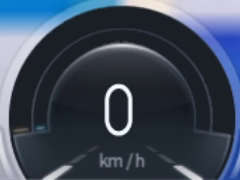


boost gauge is 0.0


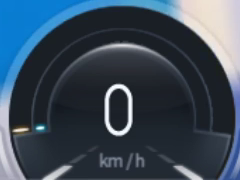


boost gauge is 0.0


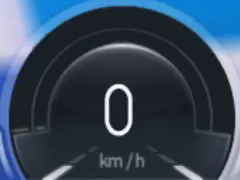


boost gauge is 0.0


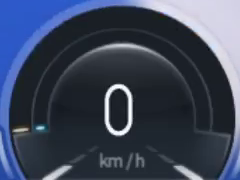


boost gauge is 0.0


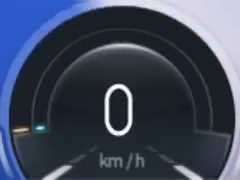


boost gauge is 0.0


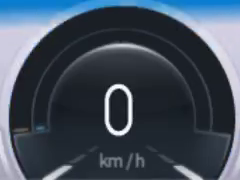


boost gauge is 0.0


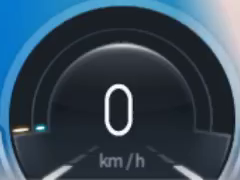


boost gauge is 0.0


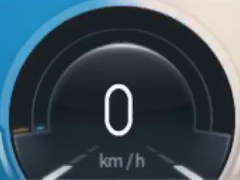


boost gauge is 0.0


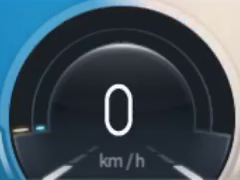


boost gauge is 0.0


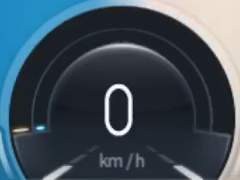


boost gauge is 0.0


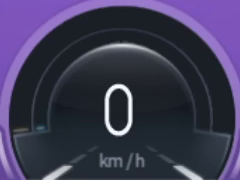


boost gauge is 0.0


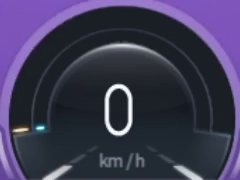


boost gauge is 0.0


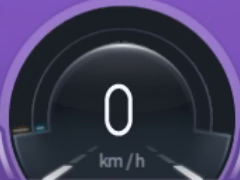


boost gauge is 0.0


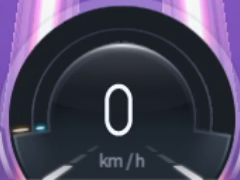


boost gauge is 0.0


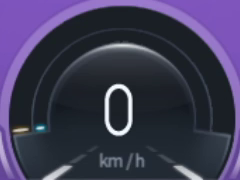


boost gauge is 0.0


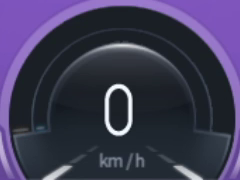


boost gauge is 0.0


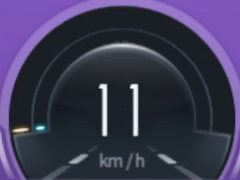


boost gauge is 0.0


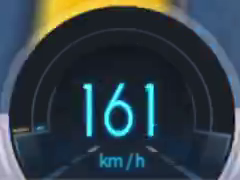


boost gauge is 0.0


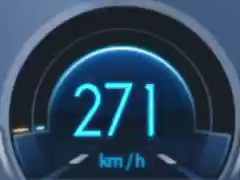


boost gauge is 0.4


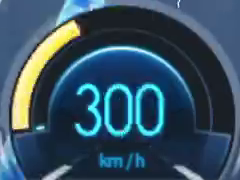


boost gauge is 1


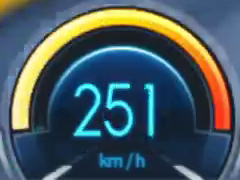


boost gauge is 0.7000000000000001


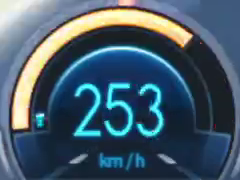


boost gauge is 0.0


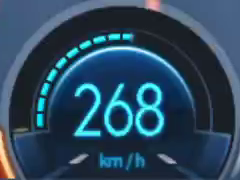


boost gauge is 0.2


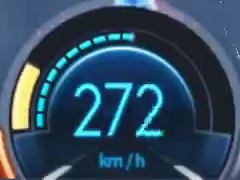


boost gauge is 0.8


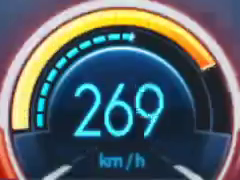


boost gauge is 0.9


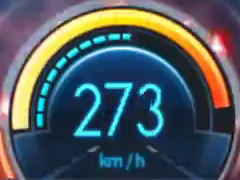


boost gauge is 1


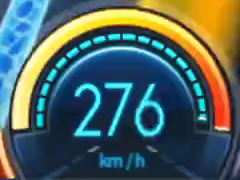


boost gauge is 0.30000000000000004


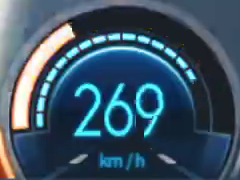


boost gauge is 0.6000000000000001


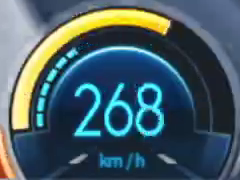


boost gauge is 1


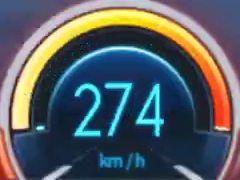


boost gauge is 1


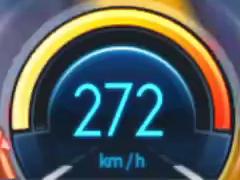


boost gauge is 0.8


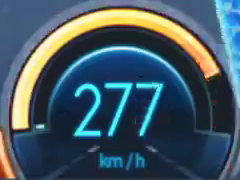


boost gauge is 0.8


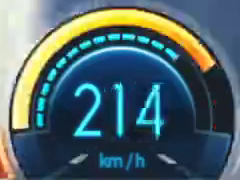


boost gauge is 1


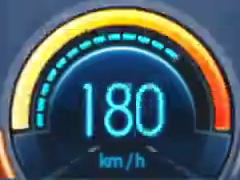


boost gauge is 0.1


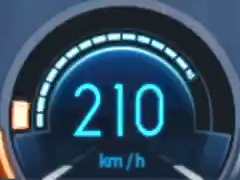


boost gauge is 0.0


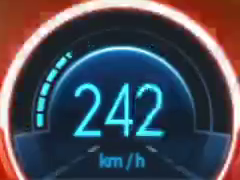


boost gauge is 0.0


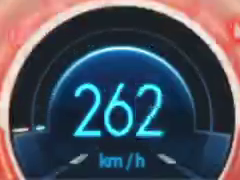


boost gauge is 0.0


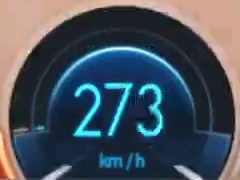


boost gauge is 0.0


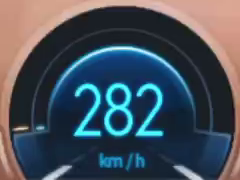


boost gauge is 0.0


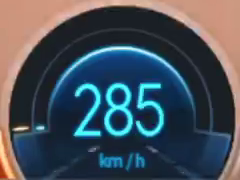


boost gauge is 0.0


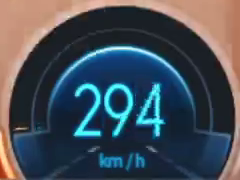


boost gauge is 0.6000000000000001


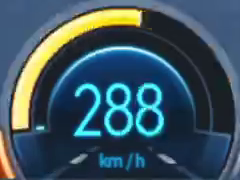


boost gauge is 1


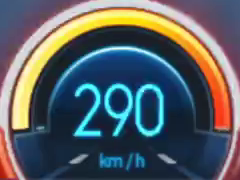


boost gauge is 0.1


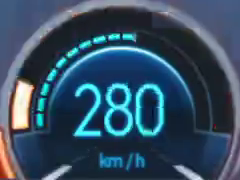


boost gauge is 1


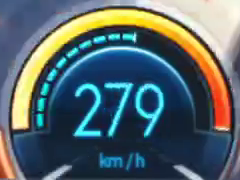


boost gauge is 0.7000000000000001


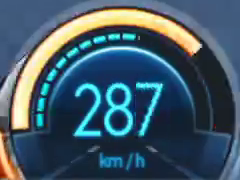


boost gauge is 0.0


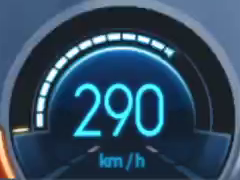


boost gauge is 0.0


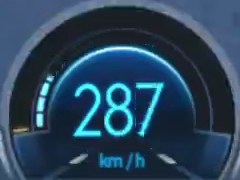


boost gauge is 0.0


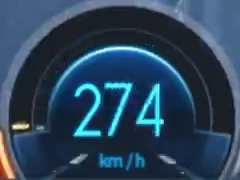


boost gauge is 0.0


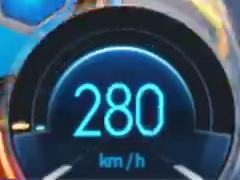

KeyboardInterrupt: ignored

In [31]:
for t in tqdm(np.arange(start_sec, end_sec, interval)):
    cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
    ret,frame = cap.read()

    if not ret:
        print("영상 시간 초과 또는 영상 관련 오류")


    '''  
    # 계기판 이미지 출력 후 비교
    gaugeimg_total = cv2.cvtColor(frame[int(gauge100pos[1]):int(gauge100pos[1]+gauge_h),
                                    int(gauge100pos[0]):int(gauge001pos[0]+gauge_w)],
                                cv2.COLOR_BGR2GRAY)
    _, gauge_thresh = cv2.threshold(gaugeimg_total, 135, 255, cv2.THRESH_BINARY)
    plt.imshow(gauge_thresh,cmap='gray')
    plt.title(speed)
    plt.show()
    '''

    '''
    cv2_imshow(frame[1030:,550:600])
    hsv = cv2.cvtColor(frame[1045:1050,598:603], cv2.COLOR_BGR2HSV)
    rgb = cv2.cvtColor(frame[1045:1050,598:603], cv2.COLOR_BGR2RGB)
    print(f'R average : {np.average(rgb[:,:,0])}')
    print(f'G average : {np.average(rgb[:,:,1])}')
    print(f'B average : {np.average(rgb[:,:,2])}')
    print(f'H average : {np.average(hsv[:,:,0])}')
    print(f'S average : {np.average(hsv[:,:,1])}')
    print(f'V average : {np.average(hsv[:,:,2])}')
    '''
        
    # 계기판 속도
    speed = gauge_speed(frame)
    # 부스터 ON/OFF 여부
    boost = boost_v1(frame)
    # 부스터 충전 게이지
    boost_percent = boost_range(frame)

    # 키 입력 추출
    key_array = [is_pushed(frame[index[1]:index[1]+key_size,index[0]:index[0]+key_size]) for index in key_pos]

    # 추출된 키 입력을 string type 변경
    keystring = ''.join(str(key) for key in key_array)
    #print(f"key string at {t} is {keystring}")

    # 게임 화면만 저장
    cropped_img = frame[:1080,:1440]
    minimap_img = frame[401:637, 1164:1416]
    #cv2_imshow(frame[881:1080,1056:1440])
    # 이미지 파일에서 키 뷰어부분 마스킹
    frame[881:1080,1056:1440] = 0

    # 이미지 저장 경로
    imgpath1 = os.path.join(capdir1, f"t{t}.jpg")
    imgpath2 = os.path.join(capdir2, f"t{t}.jpg")
    
    # 이미지 저장
    cv2.imwrite(os.path.join(drivepath, imgpath1), cropped_img)
    cv2.imwrite(os.path.join(drivepath, imgpath2), minimap_img)

    # csv 파일 저장 (이전 이미지 저장 경로, 이전 이미지 속도, 입력)
    wrcsv.writerow([prevpath, prevminimap, prevspeed, prevboost, prevboost_percent, keystring])
    
    t += interval
    prevpath = imgpath1
    prevminimap = imgpath2
    prevspeed = speed
    prevboost = boost
    prevboost_percent = boost_percent


In [ ]:
cap.release()
fcsv.close()

In [ ]:
np.arange(0,1.1,0.1)